In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emg-4/1.csv
/kaggle/input/emg-4/3.csv
/kaggle/input/emg-4/2.csv
/kaggle/input/emg-4/0.csv


In [2]:
import numpy as np   # linear algebra
import matplotlib.pylab as plt

import pandas as pd   # data processing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.layers import BatchNormalization, Dropout
from keras.layers import Dense, Activation
from tensorflow import keras


from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB


plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["lines.linewidth"] = 2
plt.style.use("ggplot")

In [3]:
df0 = pd.read_csv("../input/emg-4/0.csv", header=None )   
df1 = pd.read_csv("../input/emg-4/1.csv", header=None )
df2 = pd.read_csv("../input/emg-4/2.csv", header=None )
df3 = pd.read_csv("../input/emg-4/3.csv", header=None )

df = pd.concat([df0,df1,df2,df3], axis = 0)
#df.head()

In [4]:
x = df.loc[:,0:63]
y = df[64]

y.unique()

array([0, 1, 2, 3])

In [5]:
x = np.array(x)   
y= np.array(y)

In [6]:
x = x.reshape(x.shape[0]*x.shape[1], 1)

sc = StandardScaler()
x = sc.fit_transform(x)
x = x.reshape((-1, 8, 8))

In [7]:
print("All Data size X and y")
print(x.shape)
print(y.shape)

All Data size X and y
(11678, 8, 8)
(11678,)


In [8]:
y = np.eye(np.max(y) + 1)[y]

In [9]:
#Here we save some parameters which will be usefull later

l0 = len(df0[64])
l1 = len(df1[64])
l2 = len(df2[64])
l3 = len(df3[64])

all_lj = [l0, l1, l2, l3]

#l_sum = l0+l1+l2+l3   #For debugging
#l_tot = len(y)        #For debugging

print(all_lj)
#print(l_sum, l_tot)   #For debugging

[2910, 2903, 2943, 2922]


In [10]:
#We calculate how many rows each repetition of each sign have got (there is an uncertainty of ± 1):

l_rep0 = round(l0/6)
l_rep1 = round(l1/6)
l_rep2 = round(l2/6)
l_rep3 = round(l3/6)

n_signs = 4
n_rep = 6
n_rep_tot = 6*n_signs

l_rep = [l_rep0, l_rep1, l_rep2, l_rep3]
l_repi_tot = sum(l_rep)   #how many rows there are considering repetitions i-th from the whole 4 signs 

print(l_rep0,'+', l_rep1,'+', l_rep2,'+', l_rep3,'=', l_repi_tot)

485 + 484 + 490 + 487 = 1946


In [11]:
print(l_rep)

[485, 484, 490, 487]


In [12]:
rep_lst_x = []
rep_lst_y = []

for i in range(n_rep):
    
    #print('\nREPETITION # ',i+1,':\n')   #For debugging
    
    repi_x = np.zeros(shape=(0,8,8))
    repi_y = np.zeros(shape=(0,4))
    
    for j in range(n_signs):
        
        #print('   SIGN # ',j,':')   #For debugging
        
        #We define a byas which allows to start counting from the first row of the j-th sign
        #E.g.: j=2 ⇾ scissors in df rows [5813;8756[, 
        #so we have to start counting from b = 2910 (# rock rows) + 2913 (# paper rows) = 5813
        
        b = 0
        for a in range(j):   b = b+all_lj[a]
        #print('      b=',b,'   l_rep[j]=', l_rep[j],'\n')   #For debugging
        
        l_repj = l_rep[j]
        
        bp_0 = b + i*l_repj
        bp_1 = b + (i+1)*l_repj
        
        #print('\nBreakpoints for sign ',j,' repetition ',i,' are:   ',bp_0,'   ',bp_1-1)
        
        repi_xj = x[bp_0: bp_1]
        repi_yj = y[bp_0: bp_1]
        
        repi_x = np.concatenate((repi_x,repi_xj), axis=0)
        repi_y = np.concatenate((repi_y,repi_yj), axis=0)
        
    rep_lst_x.append(list(repi_x))
    rep_lst_y.append(list(repi_y))

#print('\n',len(rep_lst_x),'\n')   #For debugging 

rep1_x = np.array(rep_lst_x[0]);   rep1_y = np.array(rep_lst_y[0])
rep2_x = np.array(rep_lst_x[1]);   rep2_y = np.array(rep_lst_y[0])
rep3_x = np.array(rep_lst_x[2]);   rep3_y = np.array(rep_lst_y[0])
rep4_x = np.array(rep_lst_x[3]);   rep4_y = np.array(rep_lst_y[0])
rep5_x = np.array(rep_lst_x[4]);   rep5_y = np.array(rep_lst_y[0])
rep6_x = np.array(rep_lst_x[5]);   rep6_y = np.array(rep_lst_y[0])

#For debugging:
#print('\nRep 1 shape:',rep1_x.shape,'\nRep 2 shape:',rep2_x.shape,'\nRep 3 shape:',rep3_x.shape,'\nRep 4 shape:',rep4_x.shape,'\nRep 5 shape:',rep5_x.shape,'\nRep 6 shape:',rep6_x.shape )
print('OK')

OK


In [13]:
x_test = rep6_x
y_test = rep6_y

print("\nTest Data size X and y")
print(x_test.shape)
print(y_test.shape)
print('\ntest_size = ',round((x_test.shape[0]/x.shape[0])*100),'%')


Test Data size X and y
(1946, 8, 8)
(1946, 4)

test_size =  17 %


In [14]:
def build_model():

    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 8)))   

    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units = 64))
    model.add(Dense(units = 128))

    model.add(Dense(units = 4, activation="softmax"))
    model.compile(optimizer = "adam" , loss = "binary_crossentropy", metrics=["accuracy"])


    #model.summary()

    #tf.keras.utils.plot_model(model, show_shapes = True, to_file="model.png")
    
    return model

In [15]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/250
244/244 - 18s - loss: 0.4104 - accuracy: 0.5141 - val_loss: 0.2813 - val_accuracy: 0.7184
Epoch 2/250
244/244 - 8s - loss: 0.2153 - accuracy: 0.8115 - val_loss: 0.1208 - val_accuracy: 0.9157
Epoch 3/250
244/244 - 8s - loss: 0.1163 - accuracy: 0.9171 - val_loss: 0.0827 - val_accuracy: 0.9476
Epoch 4/250
244/244 - 8s - loss: 0.0841 - accuracy: 0.9427 - val_loss: 0.0566 - val_accuracy: 0.9661
Epoch 5/250
244/244 - 8s - loss: 0.0727 - accuracy: 0.9547 - val_loss: 0.0493 - val_accuracy: 0.9687
Epoch 6/250
244/244 - 8s - loss: 0.0636 - accuracy: 0.9597 - val_loss: 0.0459 - val_accuracy: 0.9671
Epoch 7/250
244/244 - 8s - loss: 0.0568 - accuracy: 0.9644 - val_loss: 0.0422 - val_accuracy: 0.9707
Epoch 8/250
244/244 - 8s - loss: 0.0526 - accuracy: 0.9657 - val_loss: 0.0389 - val_accuracy: 0.9723
Epoch 9/250
244/244 - 8s - loss: 0.0477 - accuracy: 0.9696 - val_loss: 0.0512 - val_accuracy: 0.9676
Epoch 10/250
244/244 - 8s - loss: 0.0452 - accuracy: 0.9712 - val_loss: 0.0601 - val_accur

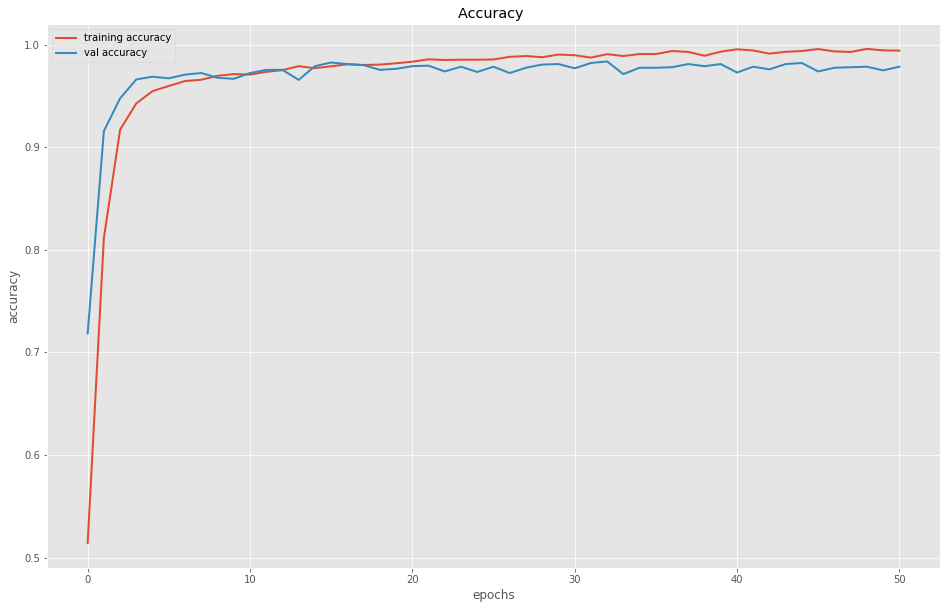

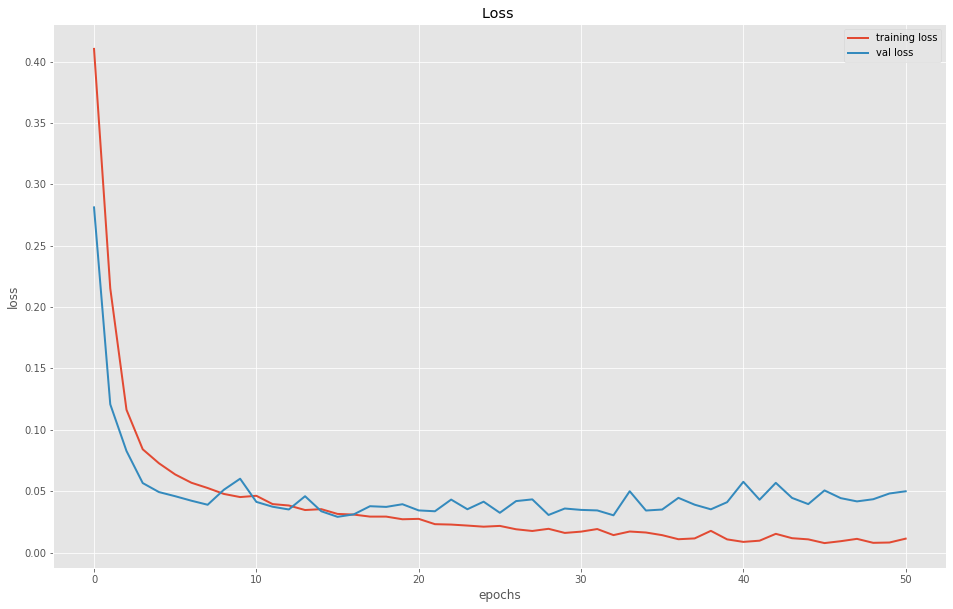

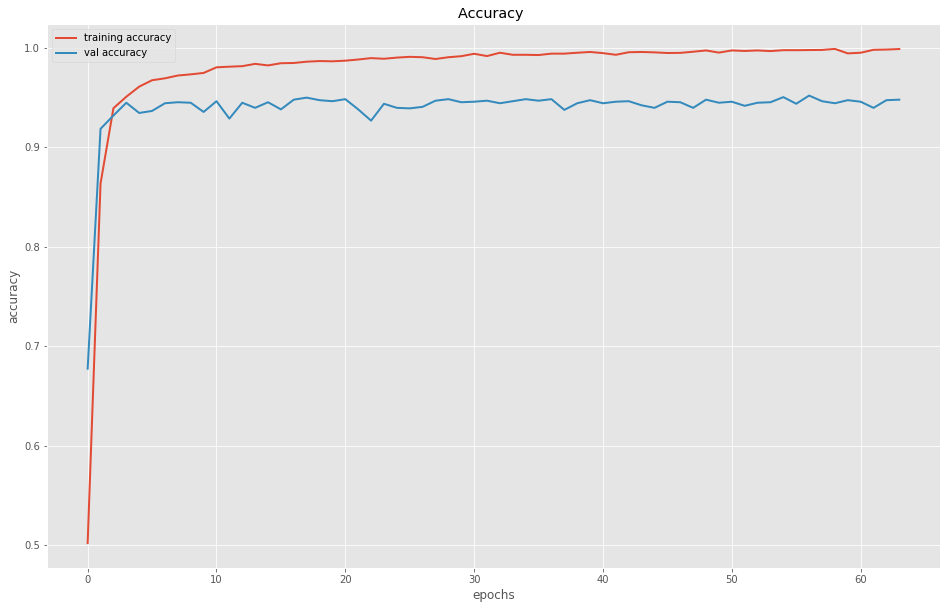

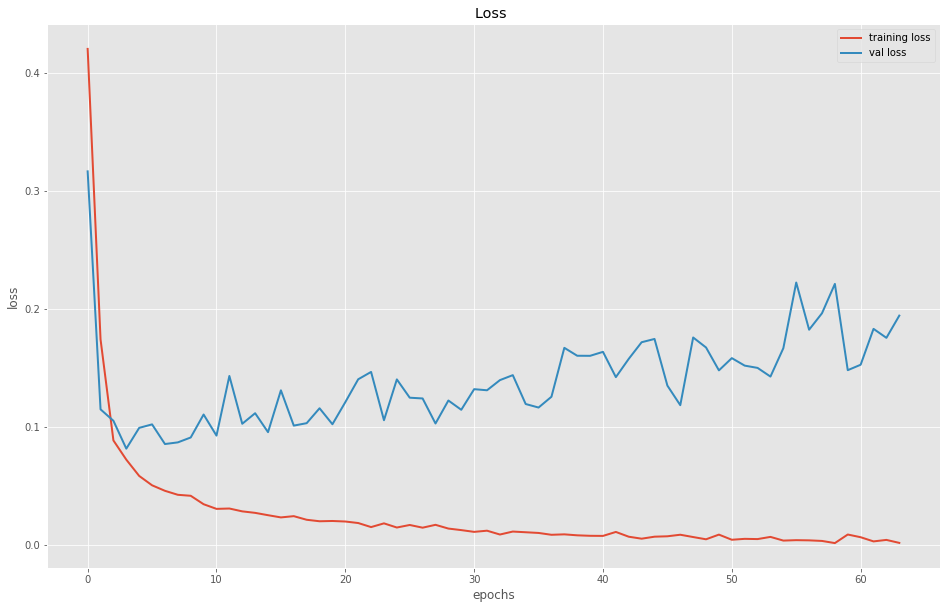

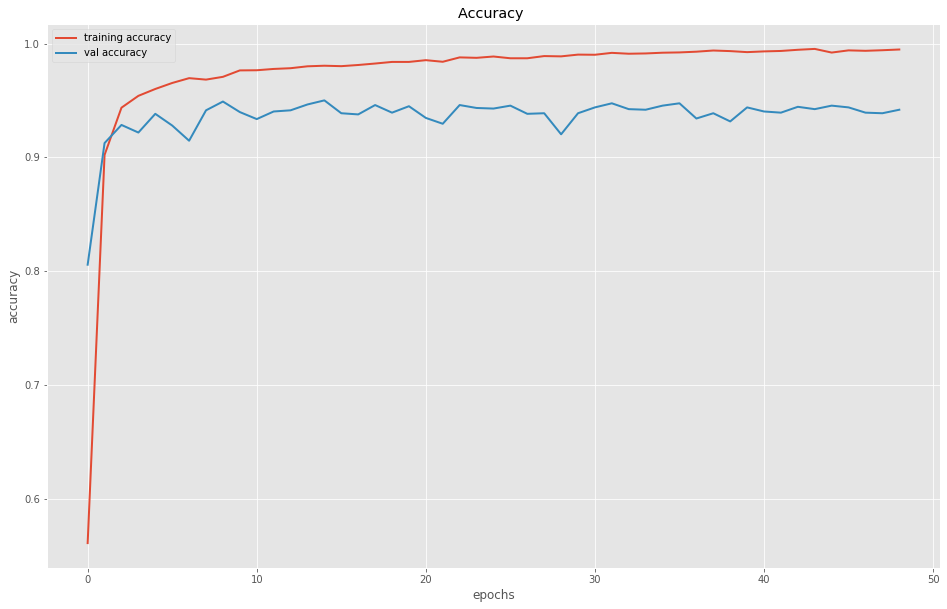

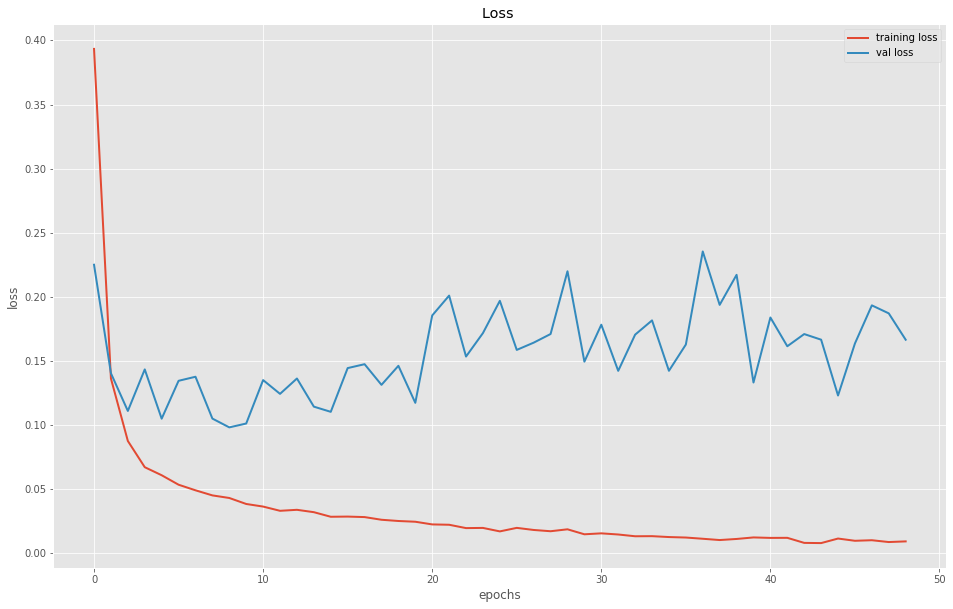

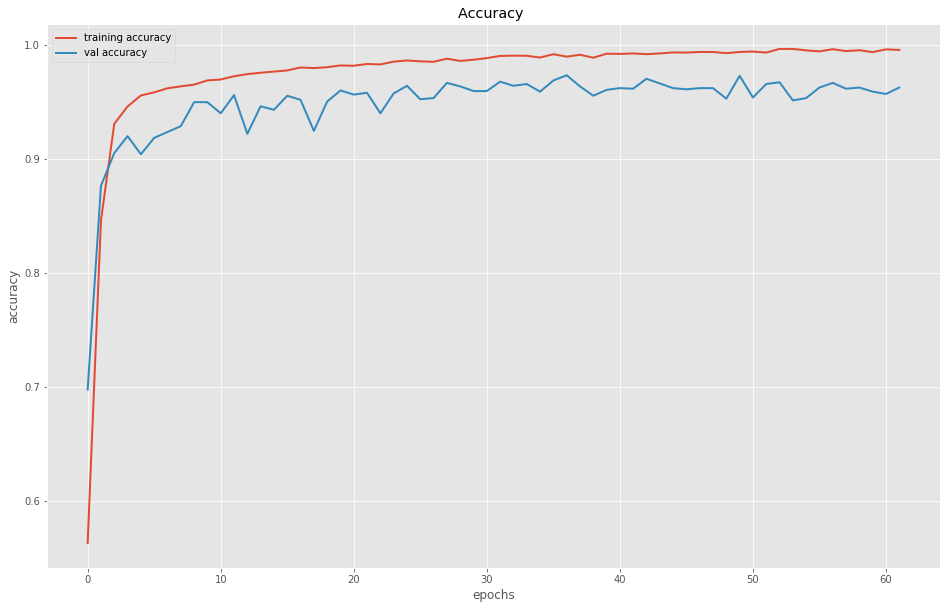

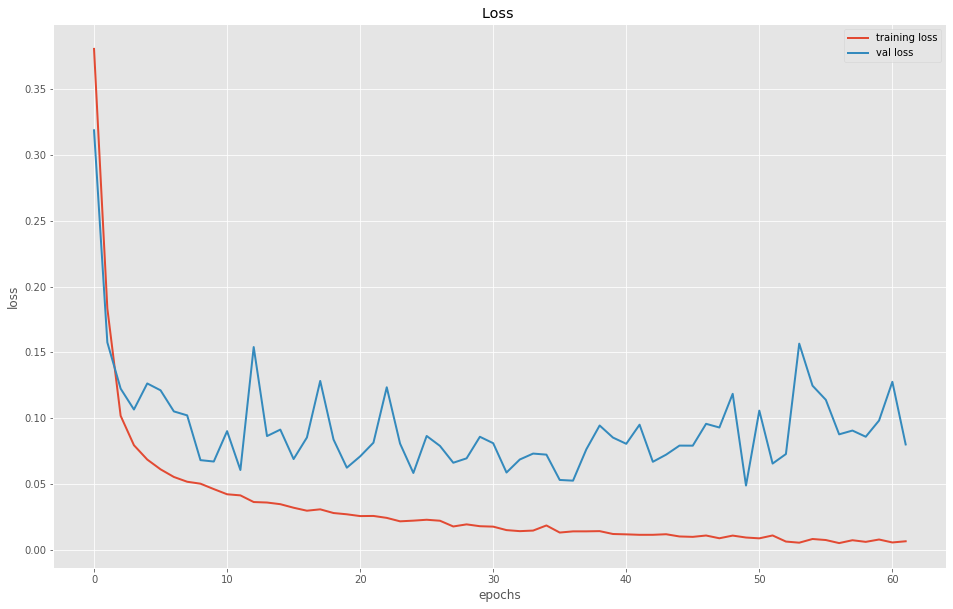

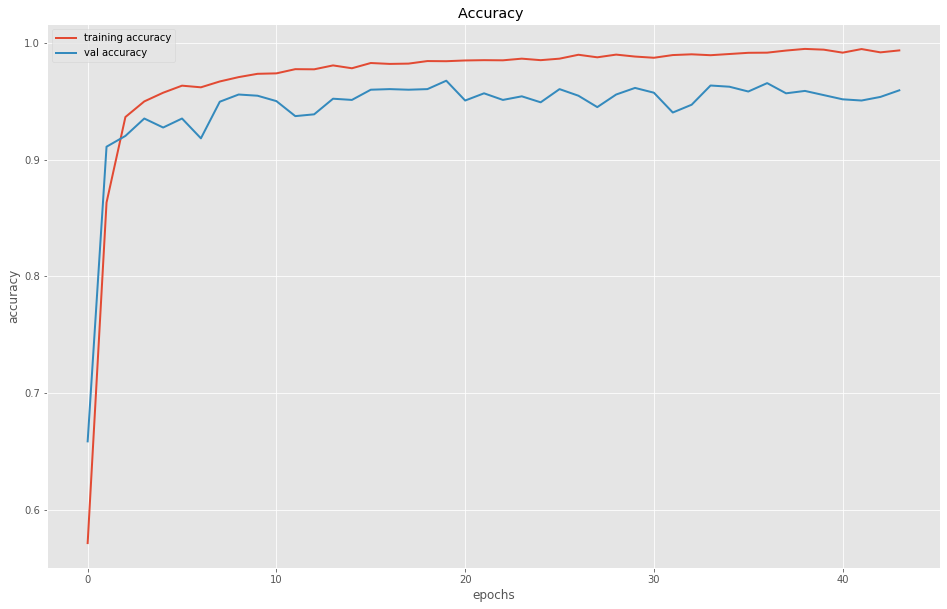

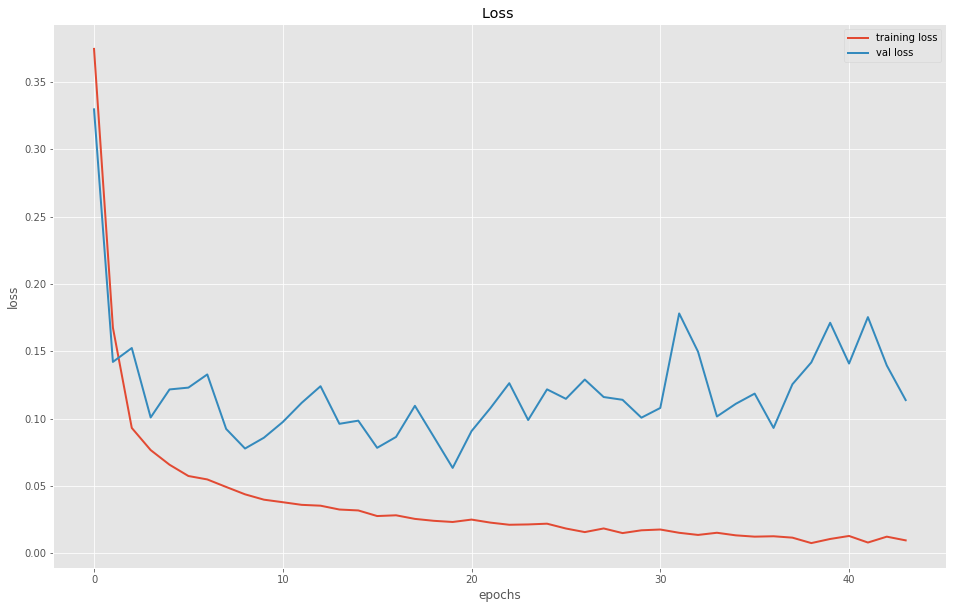

In [16]:
#CROSS VALIDATION

#To simplify the code we decided to choose a 5-folds cross validation where each fold corresponds to each repetition.
#It's important to observe that each repetition repi_x, defined before, includes of the i-th repetition of each sign so it's 
#well balanced and stratification is guaranteed.

k = n_rep-1   #5

rep_lst_x.pop(5)   #delete rep6_x from the list of repetittions cause it will be used for testing
rep_lst_y.pop(5)   #delete rep6_y from the list of repetittions cause it will be used for testing
#rep_CV_x = rep_lst_x[:]
#print('\n',len(rep_CV_x),'\n')

all_accuracy_histories = [];

for i in range(k):
    
    #print(i)
    
    rep_CV_x = rep_lst_x[:]
    x_val = np.array(rep_lst_x[i])
    rep_CV_x.pop(i)
    
    rep_CV_y = rep_lst_y[:]
    y_val = np.array(rep_lst_y[i])
    rep_CV_y.pop(i)
    
    x_train = np.zeros(shape=(0,8,8))
    y_train = np.zeros(shape=(0,4))
    
    for j in range(k-1):
        
        x_train_j =  rep_CV_x[j]
        y_train_j =  rep_CV_y[j]
        
        x_train = np.concatenate((x_train, x_train_j), axis=0)
        y_train = np.concatenate((y_train, y_train_j), axis=0)
        
    #print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
    
    model = build_model()
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=250, batch_size=32, verbose=2, callbacks=[Early_Stopping])
    
    #Plot:
    
    plt.figure()

    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Accuracy ')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()

    plt.figure()
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss ')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    
    #In this part of the code we decide what we want to save for each run for each epoch.
    
    accuracy_history = history.history['val_accuracy'];   #['accuracy', 'loss', 'val_accuracy', 'val_loss']
    all_accuracy_histories.append(accuracy_history);
    print('\nK-FOLD #',i+1,': OK\n\n')   

In [17]:
#print(all_accuracy_histories)   ##For debugging
#print(len(all_accuracy_histories), len(all_accuracy_histories[0]), len(all_accuracy_histories[1]), len(all_accuracy_histories[2]), len(all_accuracy_histories[3]), len(all_accuracy_histories[4]))

all_last_accuracy_histories = []
for i in range(k):
    accuracy_history = all_accuracy_histories[i]
    last_accuracy_history = accuracy_history[-1]
    all_last_accuracy_histories.append(last_accuracy_history)

avarage_accuracy_kv = np.mean(all_last_accuracy_histories)
print(avarage_accuracy_kv)

0.9580678343772888


In [18]:
import seaborn as sns

Y_pred = model.predict(x_test)

Y_pred_classes = np.argmax(Y_pred,axis = 1)   
Y_true = np.argmax(y_test,axis = 1) 

In [19]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

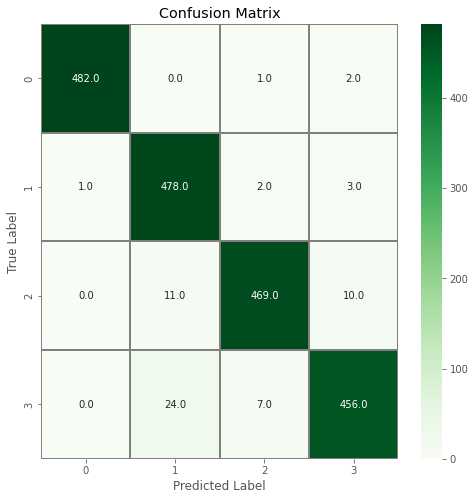

In [20]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       485
           1       0.93      0.99      0.96       484
           2       0.98      0.96      0.97       490
           3       0.97      0.94      0.95       487

    accuracy                           0.97      1946
   macro avg       0.97      0.97      0.97      1946
weighted avg       0.97      0.97      0.97      1946

